In [2]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.utils as vutils
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


# MANGA Dataset
---

### Preprocessing

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls "$content/drive/My Drive"

ls: cannot access '/drive/My Drive': No such file or directory


In [5]:
# Training and Validation data
transforms = v2.Compose([
    v2.Resize((64, 64)), # Resize to 224x224
    v2.ToTensor(),
    v2.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]), # Normalize
])

# Create Datasets for Training and Validation
PATH = '/content/drive/MyDrive/animeface-character-dataset'
train_dataset = ImageFolder(PATH, transform=transforms)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [6]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 9794
    Root location: /content/drive/MyDrive/animeface-character-dataset
    StandardTransform
Transform: Compose(
                 Resize(size=[64, 64], interpolation=InterpolationMode.BILINEAR, antialias=True)
                 ToTensor()
                 Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], inplace=False)
           )

In [7]:
# Create a DataLoader for batching and shuffling the data
dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Generator
---

In [8]:
class Generator(nn.Module):
    def __init__(self, maps = 64, noise_size = 128):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(noise_size, maps * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(maps * 8),
            nn.ReLU(True),
            # state size. (maps*8) x 4 x 4
            nn.ConvTranspose2d(maps * 8, maps * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(maps * 4),
            nn.ReLU(True),
            # state size. (maps*4) x 8 x 8
            nn.ConvTranspose2d(maps * 4, maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(maps * 2),
            nn.ReLU(True),
            # state size. (maps*2) x 16 x 16
            nn.ConvTranspose2d(maps * 2, maps, 4, 2, 1, bias=False),
            nn.BatchNorm2d(maps),
            nn.ReLU(True),
            # state size. (maps) x 32 x 32
            nn.ConvTranspose2d(maps, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. 3 x 64 x 64
        )

    def forward(self, x):
        return self.model(x)

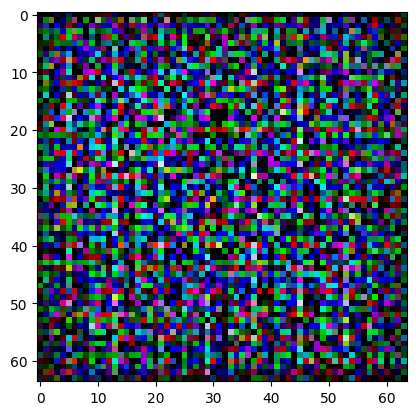

In [9]:
generator = Generator()
noise = torch.randn(64, 128, 1, 1)
output = generator(noise)
plt.imshow(output[0].detach().numpy().transpose(1, 2, 0))
plt.show()

# Discriminator
---

In [10]:
class Discriminator(nn.Module):
    def __init__(self, maps = 64):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # input is (3) x 64 x 64
            nn.Conv2d(3, maps, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (maps) x 32 x 32
            nn.Conv2d(maps, maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(maps * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (maps*2) x 16 x 16
            nn.Conv2d(maps * 2, maps * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(maps * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (maps*4) x 8 x 8
            nn.Conv2d(maps * 4, maps * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(maps * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (maps*8) x 4 x 4
            nn.Conv2d(maps * 8, 1, 4, 1, 0, bias=False),
            nn.Flatten(),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [11]:
# Instantiate the discriminator
discriminator = Discriminator()
output_discriminator = discriminator(output)
output_discriminator.shape

torch.Size([64, 1])

In [12]:
output.shape

torch.Size([64, 3, 64, 64])

# Training Loop
---

In [13]:
##### Rashmi: I wasnt sure why the train loop was in the complier model class above so tried different way below
# since we have already defined gen and disc classes we can just initialize gen, disc, optimizers, and loss
# and then run the train loop

if torch.cuda.is_available():
    print("GPU is available")
    # Print GPU device name
    print("GPU device name:", torch.cuda.get_device_name(0))  # 0 is the index of the GPU
else:
    print("GPU is not available")

generator = Generator()
discriminator = Discriminator()
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion = nn.BCELoss()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
discriminator.to(device)


# Training Loop
num_epochs = 50
latent_size = 128

for epoch in tqdm(range(num_epochs)):
    for i, (real_images, _) in enumerate(dataloader):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Create labels for real and fake images
        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)

        # Train the generator
        g_optimizer.zero_grad()
        z = torch.randn(batch_size, latent_size, 1, 1, device=device)
        fake_images = generator(z)
        outputs = discriminator(fake_images)
        g_loss = criterion(outputs, real_labels)
        g_loss.backward()
        g_optimizer.step()

        # Train the discriminator
        d_optimizer.zero_grad()
        real_outputs = discriminator(real_images)
        d_real_loss = criterion(real_outputs, real_labels)
        fake_outputs = discriminator(fake_images.detach())
        d_fake_loss = criterion(fake_outputs, fake_labels)
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()

        if (i + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], "
                  f"Generator Loss: {g_loss.item():.4f}, Discriminator Loss: {d_loss.item():.4f}")



### had to stop bc my laptop was going to explode but code is working




GPU is available
GPU device name: Tesla T4


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Step [100/307], Generator Loss: 6.1453, Discriminator Loss: 0.2665
Epoch [1/50], Step [200/307], Generator Loss: 3.7240, Discriminator Loss: 0.4588
Epoch [1/50], Step [300/307], Generator Loss: 1.6879, Discriminator Loss: 0.6687


  2%|▏         | 1/50 [03:57<3:14:10, 237.76s/it]

Epoch [2/50], Step [100/307], Generator Loss: 3.6002, Discriminator Loss: 0.3341
Epoch [2/50], Step [200/307], Generator Loss: 3.2490, Discriminator Loss: 0.2444
Epoch [2/50], Step [300/307], Generator Loss: 2.1704, Discriminator Loss: 0.1899


  4%|▍         | 2/50 [04:44<1:40:20, 125.43s/it]

Epoch [3/50], Step [100/307], Generator Loss: 0.9450, Discriminator Loss: 0.6994
Epoch [3/50], Step [200/307], Generator Loss: 2.2089, Discriminator Loss: 0.3560
Epoch [3/50], Step [300/307], Generator Loss: 3.6302, Discriminator Loss: 0.1129


  6%|▌         | 3/50 [05:30<1:09:47, 89.11s/it] 

Epoch [4/50], Step [100/307], Generator Loss: 1.3166, Discriminator Loss: 0.5185
Epoch [4/50], Step [200/307], Generator Loss: 4.0010, Discriminator Loss: 0.3613
Epoch [4/50], Step [300/307], Generator Loss: 2.8276, Discriminator Loss: 0.3596


  8%|▊         | 4/50 [06:15<55:07, 71.90s/it]  

Epoch [5/50], Step [100/307], Generator Loss: 7.1530, Discriminator Loss: 0.1512
Epoch [5/50], Step [200/307], Generator Loss: 1.9830, Discriminator Loss: 0.3095
Epoch [5/50], Step [300/307], Generator Loss: 2.5361, Discriminator Loss: 0.2945


 10%|█         | 5/50 [07:02<46:58, 62.64s/it]

Epoch [6/50], Step [100/307], Generator Loss: 4.2386, Discriminator Loss: 0.3264
Epoch [6/50], Step [200/307], Generator Loss: 2.9825, Discriminator Loss: 0.4535
Epoch [6/50], Step [300/307], Generator Loss: 2.3981, Discriminator Loss: 0.3223


 12%|█▏        | 6/50 [07:47<41:43, 56.89s/it]

Epoch [7/50], Step [100/307], Generator Loss: 0.8473, Discriminator Loss: 0.9650
Epoch [7/50], Step [200/307], Generator Loss: 2.3558, Discriminator Loss: 0.2595
Epoch [7/50], Step [300/307], Generator Loss: 1.4886, Discriminator Loss: 0.4426


 14%|█▍        | 7/50 [08:33<38:03, 53.11s/it]

Epoch [8/50], Step [100/307], Generator Loss: 2.3785, Discriminator Loss: 0.3580
Epoch [8/50], Step [200/307], Generator Loss: 1.8131, Discriminator Loss: 0.4615
Epoch [8/50], Step [300/307], Generator Loss: 3.4012, Discriminator Loss: 0.1607


 16%|█▌        | 8/50 [09:18<35:27, 50.66s/it]

Epoch [9/50], Step [100/307], Generator Loss: 4.0228, Discriminator Loss: 0.2696
Epoch [9/50], Step [200/307], Generator Loss: 3.9544, Discriminator Loss: 0.2479
Epoch [9/50], Step [300/307], Generator Loss: 3.1786, Discriminator Loss: 0.2405


 18%|█▊        | 9/50 [10:03<33:29, 49.00s/it]

Epoch [10/50], Step [100/307], Generator Loss: 7.9209, Discriminator Loss: 0.1794
Epoch [10/50], Step [200/307], Generator Loss: 5.4077, Discriminator Loss: 0.8582
Epoch [10/50], Step [300/307], Generator Loss: 0.2844, Discriminator Loss: 2.1207


 20%|██        | 10/50 [10:49<31:51, 47.79s/it]

Epoch [11/50], Step [100/307], Generator Loss: 3.2957, Discriminator Loss: 0.5564
Epoch [11/50], Step [200/307], Generator Loss: 1.8578, Discriminator Loss: 0.3798
Epoch [11/50], Step [300/307], Generator Loss: 2.0230, Discriminator Loss: 0.2647


 22%|██▏       | 11/50 [11:34<30:35, 47.07s/it]

Epoch [12/50], Step [100/307], Generator Loss: 3.1969, Discriminator Loss: 0.1381
Epoch [12/50], Step [200/307], Generator Loss: 1.8559, Discriminator Loss: 0.4806
Epoch [12/50], Step [300/307], Generator Loss: 4.9934, Discriminator Loss: 0.2058


 24%|██▍       | 12/50 [12:19<29:23, 46.41s/it]

Epoch [13/50], Step [100/307], Generator Loss: 0.9266, Discriminator Loss: 1.0183
Epoch [13/50], Step [200/307], Generator Loss: 5.9720, Discriminator Loss: 0.0556
Epoch [13/50], Step [300/307], Generator Loss: 3.0924, Discriminator Loss: 0.2506


 26%|██▌       | 13/50 [13:06<28:40, 46.51s/it]

Epoch [14/50], Step [100/307], Generator Loss: 2.0701, Discriminator Loss: 0.2525
Epoch [14/50], Step [200/307], Generator Loss: 4.4591, Discriminator Loss: 0.0488
Epoch [14/50], Step [300/307], Generator Loss: 2.9108, Discriminator Loss: 0.1682


 28%|██▊       | 14/50 [13:51<27:43, 46.22s/it]

Epoch [15/50], Step [100/307], Generator Loss: 3.5950, Discriminator Loss: 0.1145
Epoch [15/50], Step [200/307], Generator Loss: 3.3702, Discriminator Loss: 0.3190
Epoch [15/50], Step [300/307], Generator Loss: 1.2264, Discriminator Loss: 0.5242


 30%|███       | 15/50 [14:37<26:49, 45.99s/it]

Epoch [16/50], Step [100/307], Generator Loss: 1.3790, Discriminator Loss: 0.5742
Epoch [16/50], Step [200/307], Generator Loss: 1.6972, Discriminator Loss: 0.4190
Epoch [16/50], Step [300/307], Generator Loss: 3.8768, Discriminator Loss: 0.2316


 32%|███▏      | 16/50 [15:22<26:01, 45.92s/it]

Epoch [17/50], Step [100/307], Generator Loss: 0.3504, Discriminator Loss: 2.0138
Epoch [17/50], Step [200/307], Generator Loss: 3.2828, Discriminator Loss: 0.1451
Epoch [17/50], Step [300/307], Generator Loss: 8.1900, Discriminator Loss: 0.9432


 34%|███▍      | 17/50 [16:08<25:10, 45.77s/it]

Epoch [18/50], Step [100/307], Generator Loss: 5.1392, Discriminator Loss: 0.1930
Epoch [18/50], Step [200/307], Generator Loss: 2.0327, Discriminator Loss: 0.2941
Epoch [18/50], Step [300/307], Generator Loss: 3.6011, Discriminator Loss: 0.1090


 36%|███▌      | 18/50 [16:53<24:20, 45.64s/it]

Epoch [19/50], Step [100/307], Generator Loss: 4.2986, Discriminator Loss: 0.2625
Epoch [19/50], Step [200/307], Generator Loss: 2.8194, Discriminator Loss: 0.1575
Epoch [19/50], Step [300/307], Generator Loss: 6.5535, Discriminator Loss: 0.2526


 38%|███▊      | 19/50 [17:39<23:36, 45.68s/it]

Epoch [20/50], Step [100/307], Generator Loss: 2.5828, Discriminator Loss: 0.1587
Epoch [20/50], Step [200/307], Generator Loss: 5.9582, Discriminator Loss: 0.2700
Epoch [20/50], Step [300/307], Generator Loss: 1.7553, Discriminator Loss: 0.3742


 40%|████      | 20/50 [18:25<22:50, 45.68s/it]

Epoch [21/50], Step [100/307], Generator Loss: 3.2175, Discriminator Loss: 0.2006
Epoch [21/50], Step [200/307], Generator Loss: 4.5211, Discriminator Loss: 0.0678
Epoch [21/50], Step [300/307], Generator Loss: 5.0993, Discriminator Loss: 0.0559


 42%|████▏     | 21/50 [19:10<22:00, 45.55s/it]

Epoch [22/50], Step [100/307], Generator Loss: 3.3129, Discriminator Loss: 0.1668
Epoch [22/50], Step [200/307], Generator Loss: 4.3891, Discriminator Loss: 0.0820
Epoch [22/50], Step [300/307], Generator Loss: 3.1878, Discriminator Loss: 0.1661


 44%|████▍     | 22/50 [19:55<21:11, 45.42s/it]

Epoch [23/50], Step [100/307], Generator Loss: 4.1441, Discriminator Loss: 0.0389
Epoch [23/50], Step [200/307], Generator Loss: 3.2903, Discriminator Loss: 0.0922
Epoch [23/50], Step [300/307], Generator Loss: 5.1975, Discriminator Loss: 0.0864


 46%|████▌     | 23/50 [20:40<20:24, 45.37s/it]

Epoch [24/50], Step [100/307], Generator Loss: 2.8032, Discriminator Loss: 0.2533
Epoch [24/50], Step [200/307], Generator Loss: 3.0819, Discriminator Loss: 0.0828
Epoch [24/50], Step [300/307], Generator Loss: 3.4176, Discriminator Loss: 0.3205


 48%|████▊     | 24/50 [21:27<19:47, 45.68s/it]

Epoch [25/50], Step [100/307], Generator Loss: 3.6947, Discriminator Loss: 0.0490
Epoch [25/50], Step [200/307], Generator Loss: 4.7424, Discriminator Loss: 0.0721
Epoch [25/50], Step [300/307], Generator Loss: 6.4620, Discriminator Loss: 0.1985


 50%|█████     | 25/50 [22:12<18:59, 45.57s/it]

Epoch [26/50], Step [100/307], Generator Loss: 3.5971, Discriminator Loss: 0.1273
Epoch [26/50], Step [200/307], Generator Loss: 5.8712, Discriminator Loss: 0.3062
Epoch [26/50], Step [300/307], Generator Loss: 3.4072, Discriminator Loss: 0.1179


 52%|█████▏    | 26/50 [22:57<18:10, 45.46s/it]

Epoch [27/50], Step [100/307], Generator Loss: 2.4361, Discriminator Loss: 0.3130
Epoch [27/50], Step [200/307], Generator Loss: 2.1781, Discriminator Loss: 0.2442
Epoch [27/50], Step [300/307], Generator Loss: 3.4476, Discriminator Loss: 0.0858


 54%|█████▍    | 27/50 [23:43<17:27, 45.53s/it]

Epoch [28/50], Step [100/307], Generator Loss: 5.9466, Discriminator Loss: 1.5618
Epoch [28/50], Step [200/307], Generator Loss: 4.5633, Discriminator Loss: 0.1021
Epoch [28/50], Step [300/307], Generator Loss: 3.3437, Discriminator Loss: 0.2553


 56%|█████▌    | 28/50 [24:27<16:34, 45.21s/it]

Epoch [29/50], Step [100/307], Generator Loss: 8.7945, Discriminator Loss: 0.7754
Epoch [29/50], Step [200/307], Generator Loss: 6.3394, Discriminator Loss: 0.4420
Epoch [29/50], Step [300/307], Generator Loss: 5.1397, Discriminator Loss: 0.2212


 58%|█████▊    | 29/50 [25:12<15:47, 45.10s/it]

Epoch [30/50], Step [100/307], Generator Loss: 4.4558, Discriminator Loss: 0.0803
Epoch [30/50], Step [200/307], Generator Loss: 0.8496, Discriminator Loss: 0.9005
Epoch [30/50], Step [300/307], Generator Loss: 5.4851, Discriminator Loss: 0.2464


 60%|██████    | 30/50 [25:58<15:05, 45.27s/it]

Epoch [31/50], Step [100/307], Generator Loss: 4.9498, Discriminator Loss: 0.1465
Epoch [31/50], Step [200/307], Generator Loss: 1.8446, Discriminator Loss: 0.3982
Epoch [31/50], Step [300/307], Generator Loss: 3.5290, Discriminator Loss: 0.0648


 62%|██████▏   | 31/50 [26:43<14:18, 45.17s/it]

Epoch [32/50], Step [100/307], Generator Loss: 5.1700, Discriminator Loss: 0.0815
Epoch [32/50], Step [200/307], Generator Loss: 2.5174, Discriminator Loss: 0.2337
Epoch [32/50], Step [300/307], Generator Loss: 5.6393, Discriminator Loss: 0.0515


 64%|██████▍   | 32/50 [27:28<13:33, 45.20s/it]

Epoch [33/50], Step [100/307], Generator Loss: 5.2891, Discriminator Loss: 0.0286
Epoch [33/50], Step [200/307], Generator Loss: 4.1793, Discriminator Loss: 0.2540
Epoch [33/50], Step [300/307], Generator Loss: 4.0980, Discriminator Loss: 0.1321


 66%|██████▌   | 33/50 [28:15<12:55, 45.59s/it]

Epoch [34/50], Step [100/307], Generator Loss: 3.9722, Discriminator Loss: 0.0779
Epoch [34/50], Step [200/307], Generator Loss: 1.7544, Discriminator Loss: 0.3787
Epoch [34/50], Step [300/307], Generator Loss: 4.9082, Discriminator Loss: 0.0855


 68%|██████▊   | 34/50 [28:59<12:05, 45.35s/it]

Epoch [35/50], Step [100/307], Generator Loss: 1.3154, Discriminator Loss: 0.6169
Epoch [35/50], Step [200/307], Generator Loss: 3.1222, Discriminator Loss: 0.1559
Epoch [35/50], Step [300/307], Generator Loss: 4.6653, Discriminator Loss: 0.2879


 70%|███████   | 35/50 [29:44<11:18, 45.26s/it]

Epoch [36/50], Step [100/307], Generator Loss: 8.8650, Discriminator Loss: 0.1498
Epoch [36/50], Step [200/307], Generator Loss: 5.7456, Discriminator Loss: 0.0833
Epoch [36/50], Step [300/307], Generator Loss: 7.2891, Discriminator Loss: 0.4828


 72%|███████▏  | 36/50 [30:30<10:35, 45.41s/it]

Epoch [37/50], Step [100/307], Generator Loss: 5.3813, Discriminator Loss: 0.1135
Epoch [37/50], Step [200/307], Generator Loss: 6.2308, Discriminator Loss: 0.0944
Epoch [37/50], Step [300/307], Generator Loss: 3.0010, Discriminator Loss: 0.2221


 74%|███████▍  | 37/50 [31:15<09:47, 45.21s/it]

Epoch [38/50], Step [100/307], Generator Loss: 1.9948, Discriminator Loss: 0.5612
Epoch [38/50], Step [200/307], Generator Loss: 5.4474, Discriminator Loss: 0.0201
Epoch [38/50], Step [300/307], Generator Loss: 5.3077, Discriminator Loss: 0.1099


 76%|███████▌  | 38/50 [32:01<09:04, 45.37s/it]

Epoch [39/50], Step [100/307], Generator Loss: 6.2640, Discriminator Loss: 0.1223
Epoch [39/50], Step [200/307], Generator Loss: 4.1431, Discriminator Loss: 0.0569
Epoch [39/50], Step [300/307], Generator Loss: 4.0100, Discriminator Loss: 0.1715


 78%|███████▊  | 39/50 [32:46<08:19, 45.42s/it]

Epoch [40/50], Step [100/307], Generator Loss: 2.8328, Discriminator Loss: 0.2791
Epoch [40/50], Step [200/307], Generator Loss: 5.0626, Discriminator Loss: 0.0312
Epoch [40/50], Step [300/307], Generator Loss: 4.2964, Discriminator Loss: 0.0930


 80%|████████  | 40/50 [33:32<07:34, 45.42s/it]

Epoch [41/50], Step [100/307], Generator Loss: 4.6081, Discriminator Loss: 0.0538
Epoch [41/50], Step [200/307], Generator Loss: 4.4594, Discriminator Loss: 0.0302
Epoch [41/50], Step [300/307], Generator Loss: 7.5197, Discriminator Loss: 0.1410


 82%|████████▏ | 41/50 [34:17<06:48, 45.38s/it]

Epoch [42/50], Step [100/307], Generator Loss: 5.0002, Discriminator Loss: 0.0319
Epoch [42/50], Step [200/307], Generator Loss: 2.9736, Discriminator Loss: 0.2212
Epoch [42/50], Step [300/307], Generator Loss: 5.2749, Discriminator Loss: 0.0208


 84%|████████▍ | 42/50 [35:02<06:02, 45.32s/it]

Epoch [43/50], Step [100/307], Generator Loss: 2.9900, Discriminator Loss: 0.2422
Epoch [43/50], Step [200/307], Generator Loss: 4.5120, Discriminator Loss: 0.0334
Epoch [43/50], Step [300/307], Generator Loss: 4.6937, Discriminator Loss: 0.2092


 86%|████████▌ | 43/50 [35:47<05:16, 45.21s/it]

Epoch [44/50], Step [100/307], Generator Loss: 6.0138, Discriminator Loss: 0.0225
Epoch [44/50], Step [200/307], Generator Loss: 9.5897, Discriminator Loss: 1.0347
Epoch [44/50], Step [300/307], Generator Loss: 4.8397, Discriminator Loss: 0.0465


 88%|████████▊ | 44/50 [36:32<04:31, 45.24s/it]

Epoch [45/50], Step [100/307], Generator Loss: 5.1622, Discriminator Loss: 0.0388
Epoch [45/50], Step [200/307], Generator Loss: 4.6487, Discriminator Loss: 0.0252
Epoch [45/50], Step [300/307], Generator Loss: 4.1619, Discriminator Loss: 0.0559


 90%|█████████ | 45/50 [37:17<03:46, 45.20s/it]

Epoch [46/50], Step [100/307], Generator Loss: 3.7052, Discriminator Loss: 0.0765
Epoch [46/50], Step [200/307], Generator Loss: 3.8404, Discriminator Loss: 0.0869
Epoch [46/50], Step [300/307], Generator Loss: 2.7992, Discriminator Loss: 0.1910


 92%|█████████▏| 46/50 [38:02<03:00, 45.11s/it]

Epoch [47/50], Step [100/307], Generator Loss: 4.9497, Discriminator Loss: 0.0387
Epoch [47/50], Step [200/307], Generator Loss: 7.8650, Discriminator Loss: 0.0778
Epoch [47/50], Step [300/307], Generator Loss: 4.5557, Discriminator Loss: 0.0987


 94%|█████████▍| 47/50 [38:48<02:16, 45.37s/it]

Epoch [48/50], Step [100/307], Generator Loss: 3.1255, Discriminator Loss: 0.3781
Epoch [48/50], Step [200/307], Generator Loss: 5.8731, Discriminator Loss: 0.0398
Epoch [48/50], Step [300/307], Generator Loss: 5.1070, Discriminator Loss: 0.1477


 96%|█████████▌| 48/50 [39:33<01:30, 45.17s/it]

Epoch [49/50], Step [100/307], Generator Loss: 3.2406, Discriminator Loss: 0.2097
Epoch [49/50], Step [200/307], Generator Loss: 5.2854, Discriminator Loss: 0.0372
Epoch [49/50], Step [300/307], Generator Loss: 6.1587, Discriminator Loss: 0.0778


 98%|█████████▊| 49/50 [40:17<00:44, 44.97s/it]

Epoch [50/50], Step [100/307], Generator Loss: 5.1864, Discriminator Loss: 0.0381
Epoch [50/50], Step [200/307], Generator Loss: 7.3066, Discriminator Loss: 0.0469
Epoch [50/50], Step [300/307], Generator Loss: 6.7048, Discriminator Loss: 0.1135


100%|██████████| 50/50 [41:03<00:00, 49.26s/it]


In [14]:
# save model as pickle
import pickle

with open('generator.pkl', 'wb') as f:
    pickle.dump(generator, f)

with open('discriminator.pkl', 'wb') as f:
    pickle.dump(discriminator, f)

In [15]:
# Load the generator model
generator = pickle.load(open('generator.pkl', 'rb'))

In [16]:
# Generate samples for visualization
with torch.no_grad():
    z = torch.randn(4, latent_size, 1, 1).to(device)
    fake_samples = generator(z).reshape(-1, 3, 64, 64)
    fake_samples = (fake_samples + 1) / 2  # Rescale to [0, 1] for visualization



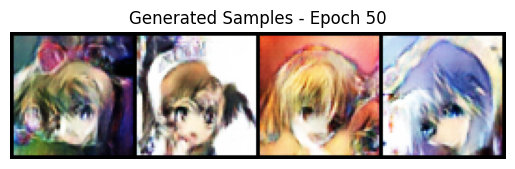

In [17]:
# Visualize generated samples
grid_img = vutils.make_grid(fake_samples.cpu(), nrow=4, padding=2, normalize=True)
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis("off")
plt.title(f"Generated Samples - Epoch {epoch+1}")
plt.show()

In [18]:
# pass real image into generator

import torch
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image

# Load and preprocess the image
img_path = '/content/drive/MyDrive/animeface-character-dataset/data/face_1254_484_37.png'
img = Image.open(img_path)

# Resize the image to match the expected input size of the CNN model
resize_transform = transforms.Resize((224, 224))
img_resized = resize_transform(img)

# Convert the image to a tensor and normalize it
to_tensor_transform = transforms.ToTensor()
normalize_transform = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
img_tensor = normalize_transform(to_tensor_transform(img_resized)).unsqueeze(0)

# Load a pre-trained ResNet model
resnet = models.resnet50(pretrained=True)

# Set the model to evaluation mode
resnet.eval()

# Extract features from the image using the ResNet model
with torch.no_grad():
    features = resnet(img_tensor)

# Use a linear layer to reduce the number of channels to 128
linear_layer = torch.nn.Linear(in_features=features.size(1), out_features=128)
features_reduced = linear_layer(features.squeeze()).unsqueeze(-1).unsqueeze(-1)

# Add an extra dimension at the beginning
features_reduced = features_reduced.unsqueeze(0)

# Further processing or use of the feature map
print(features_reduced.shape)  # Output: torch.Size([1, 128, 1, 1])


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 154MB/s]


torch.Size([1, 128, 1, 1])


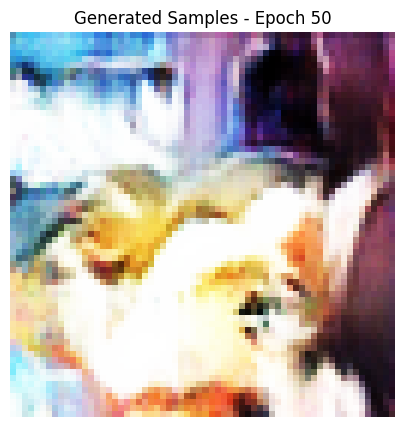

In [21]:
fake_samples = generator(features_reduced.to(device)).reshape(-1, 3, 64, 64)
# Visualize generated samples
grid_img = vutils.make_grid(fake_samples.cpu(), nrow=4, padding=2, normalize=True)
plt.figure(figsize=(5, 5))
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis("off")
plt.title(f"Generated Samples - Epoch {epoch+1}")
plt.show()

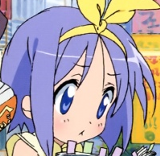

In [22]:
img